### Evaluate the cross-validation models

Compared to cross_validation_evaluate.ipynb in the column-based model it sufficed to <br>
i) Change the names from column to cell, <br>
ii) add leaky_relu, <br>
iii) load layers_data and adapt the function mean_clc_per_vertical_layer accordingly

Throws error: /var/log/slurm/spool_slurmd//job30647618/slurm_script: line 22: 69938 Segmentation fault      python ${path}/${python_script}.py

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import gc

#Import sklearn before tensorflow (static Thread-local storage)
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.errors import ResourceExhaustedError
import tensorflow as tf

# Add path with my_classes to sys.path
path = '/pf/b/b309170'
sys.path.insert(0, path + '/workspace_icon-ml/cloud_cover_parameterization/')

import my_classes
from my_classes import write_infofile

# For Leaky_ReLU:
from tensorflow import nn 

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(physical_devices[0], 'GPU')

In [3]:
# Won't run on a CPU node
try:
    # Prevents crashes of the code
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.set_visible_devices(physical_devices[0], 'GPU')
    # Allow the growth of memory Tensorflow allocates (limits memory usage overall)
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except:
    pass

In [4]:
# Cloud Cover or Cloud Area?
output_var = 'clc' # Set output_var to one of {'clc', 'cl_area'}
# QUBICC only or QUBICC+NARVAL training data?
qubicc_only = True
# Do we evaluate a model trained on all data?
all_data_model = False

path_base = os.path.join(path, 'workspace_icon-ml/cloud_cover_parameterization/region_based_one_nn_R02B05')
path_data = os.path.join(path, 'my_work/icon-ml_data/cloud_cover_parameterization/region_based_one_nn_R02B05/based_on_var_interpolated_data')

if output_var == 'clc':
    full_output_var_name = 'cloud_cover'
elif output_var == 'cl_area':
    full_output_var_name = 'cloud_area'
    
if qubicc_only:
    output_folder = '%s_R2B5_QUBICC'%full_output_var_name
else:
    output_folder = '%s_R2B5_QUBICC+NARVAL'%full_output_var_name
path_model = os.path.join(path_base, 'saved_models', output_folder)
path_figures = os.path.join(path_base, 'figures', output_folder)
narval_output_file = '%s_output_narval.npy'%full_output_var_name
qubicc_output_file = '%s_output_qubicc.npy'%full_output_var_name

#### Load models

In [5]:
# def lrelu(x):
#     return nn.leaky_relu(x, alpha=0.01)

custom_objects = {}
custom_objects['leaky_relu'] = nn.leaky_relu

In [6]:
fold_1 = 'cross_validation_region_based_fold_1.h5'
fold_2 = 'cross_validation_region_based_fold_2.h5'
fold_3 = 'cross_validation_region_based_fold_3.h5'

model_fold_1 = load_model(os.path.join(path_model, fold_1), custom_objects)
model_fold_2 = load_model(os.path.join(path_model, fold_2), custom_objects)
model_fold_3 = load_model(os.path.join(path_model, fold_3), custom_objects)

if all_data_model:
    all_data = 'region_based_all_data_seed_10.h5'
    model_all_data = load_model(os.path.join(path_model, all_data), custom_objects)

# model_fold_1 = load_model(os.path.join(path_model, fold_1))
# model_fold_2 = load_model(os.path.join(path_model, fold_2))
# model_fold_3 = load_model(os.path.join(path_model, fold_3))

#### Load data

In [7]:
os.listdir(path_data)

['cloud_cover_input_qubicc.npy',
 'samples_vertical_layers_qubicc.npy',
 'cloud_area_output_qubicc.npy',
 'samples_vertical_layers_narval.npy',
 'cloud_area_output_narval.npy',
 'cloud_cover_output_qubicc.npy',
 'cloud_cover_input_narval.npy',
 'cloud_cover_output_narval.npy']

In [9]:
input_data = np.concatenate((np.load(path_data + '/cloud_cover_input_narval.npy'), 
                             np.load(path_data + '/cloud_cover_input_qubicc.npy')), axis=0)
output_data = np.concatenate((np.load(os.path.join(path_data, narval_output_file)), 
                              np.load(os.path.join(path_data, qubicc_output_file))), axis=0)

In [10]:
layers_data = np.concatenate((np.load(path_data + '/samples_vertical_layers_narval.npy'), 
                              np.load(path_data + '/samples_vertical_layers_qubicc.npy')), axis=0)

In [6]:
samples_narval = np.load(os.path.join(path_data, narval_output_file)).shape[0]

In [11]:
(samples_total, no_of_features) = input_data.shape

#### Define cross-validation folds to recreate training and validation data

In [78]:
def set_training_validation_folds(samples_total, samples_narval):
    training_folds = []
    validation_folds = []
    two_week_incr = (samples_total-samples_narval)//6

    for i in range(3):
        # Note that this is a temporal split since time was the first dimension in the original tensor
        first_incr = np.arange(samples_narval+two_week_incr*i, samples_narval+two_week_incr*(i+1))
        second_incr = np.arange(samples_narval+two_week_incr*(i+3), samples_narval+two_week_incr*(i+4))
        
        print(second_incr)

        validation_folds.append(np.append(first_incr, second_incr))
        training_folds.append(np.arange(samples_narval, samples_total))
        training_folds[i] = np.setdiff1d(training_folds[i], validation_folds[i])
        
    return training_folds, validation_folds

if qubicc_only:
    # We have to skip the NARVAL data if we do qubicc_only
    training_folds, validation_folds = set_training_validation_folds(samples_total, samples_narval)
else:
    training_folds, validation_folds = set_training_validation_folds(samples_total, 0)

[69 70 71 72 73 74 75 76 77 78 79 80]
[81 82 83 84 85 86 87 88 89 90 91 92]
[ 93  94  95  96  97  98  99 100 101 102 103 104]


#### The data will need to be scaled according to the training folds

In [18]:
scaler = StandardScaler()

#### Useful functions to plot results

In [13]:
def mean_clc_per_vertical_layer(model, input_data, output_data, layers_data, batch_size=2**20):
    '''
        Input: 
            model: neural network
            input_data: Usually the validation data
            output_data: The ground truth output
            layers_data: Vector that tells us the vertical layer of a given sample
            
        Model prediction and the Ground Truth means per vertical layer
    '''
    # Predicted output_var means
    # Curiously it works best if we use predict_on_batch on small subsets of the data instead of predict(..., batch_size=...) 
    for i in range(1 + input_data.shape[0]//batch_size):
        if i == 0:
            a = model.predict_on_batch(input_data[i*batch_size:(i+1)*batch_size])
        else:
            a = np.concatenate((a, model.predict_on_batch(input_data[i*batch_size:(i+1)*batch_size])), axis=0)
        K.clear_session()
        gc.collect()
        
    pred_adj = np.minimum(np.maximum(a, 0), 100)
    
    # Computing means with the help of layers_data
    clc_pred_mean = []; clc_data_mean = [];
    for i in range(5, 32):
        ind = np.where(layers_data == i)
        clc_data_mean.append(np.mean(output_data[ind], dtype=np.float64))
        clc_pred_mean.append(np.mean(pred_adj[ind], dtype=np.float64))
    
    return clc_pred_mean, clc_data_mean

In [24]:
def save_figure(fig_name, fig_title, model_predictions, valid_means=None, all_data_model=False):
    '''
        Note that this figure truly is a different performance measure than the validation error.
        The reason is that the mean can in principle be good even when the model is really bad.
        
        model_predictions: Array of length 3 or 4, covers predictions from all three folds for a given TL setup
        valid_means: Array of length 3 or 4, covers validation means from all three folds for a given TL setup
   '''
#     assert len(model_biases) == 3
    
    # Vertical layers
    a = np.linspace(5, 31, 27)
    fig = plt.figure(figsize=(11,7))
    # For model
    ax = fig.add_subplot(111, xlabel='Mean %s'%output_var, ylabel='Vertical layer', title=fig_title)
    
    if all_data_model:    
        if not valid_means[0] == valid_means[1] == valid_means[2]:
            colors = ['g', 'b', 'r']
            for i in range(len(model_predictions)):
                ax.plot(model_predictions[i], a, colors[i])
                if valid_means != None:
                    ax.plot(valid_means[i], a, '%s--'%colors[i])
            plt.gca().invert_yaxis()
            ax.legend(['Model Fold 1 Predictions', 'Fold 1 Truth', 'Model Fold 2 Predictions', 'Fold 2 Truth', 
                       'Model Fold 3 Predictions', 'Fold 3 Truth', 'Model All Data Predictions', 'Truth'])
        else:
            for i in range(len(model_predictions)):
                ax.plot(model_predictions[i], a)
            ax.plot(valid_means[0], a, 'black')
            plt.gca().invert_yaxis()
            ax.legend(['Model Fold 1 Predictions', 'Model Fold 2 Predictions', 'Model Fold 3 Predictions', 
                       'Model All Data Predictions', 'Truth'])
    else:
        if not valid_means[0] == valid_means[1] == valid_means[2]:
            colors = ['g', 'b', 'r']
            for i in range(len(model_predictions)):
                ax.plot(model_predictions[i], a, colors[i])
                if valid_means != None:
                    ax.plot(valid_means[i], a, '%s--'%colors[i])
            plt.gca().invert_yaxis()
            ax.legend(['Model Fold 1 Predictions', 'Fold 1 Truth', 'Model Fold 2 Predictions', 'Fold 2 Truth', 
                       'Model Fold 3 Predictions', 'Fold 3 Truth'])
        else:
            for i in range(len(model_predictions)):
                ax.plot(model_predictions[i], a)
            ax.plot(valid_means[0], a, 'black')
            plt.gca().invert_yaxis()
            ax.legend(['Model Fold 1 Predictions', 'Model Fold 2 Predictions', 'Model Fold 3 Predictions', 
                       'Truth'])

    fig.savefig(os.path.join(path_figures, fig_name+'.pdf'))

#### Evaluate the models on the data

Add training and validation losses to the text files. <br>
Print results per vertical layer (respective validation set/NARVAL/QUBICC)

In [15]:
train_losses = [] ; valid_losses = [] ; valid_means = [] ; valid_model_predictions = [] ;
narval_means = [] ; narval_model_predictions = [] ; qubicc_means = [] ; qubicc_model_predictions = [] ;
qubicc_month_0 = [] ; qubicc_model_pred_month_0 = [] ; qubicc_month_1 = [] ; qubicc_model_pred_month_1 = [] ;
qubicc_month_2 = [] ; qubicc_model_pred_month_2 = [] ;

In [14]:
for i in range(3): 
    filename = 'cross_validation_region_based_fold_%d'%(i+1)
    # Choose appropriate model for this fold
    if i == 0: model = model_fold_1
    if i == 1: model = model_fold_2
    if i == 2: model = model_fold_3
    
    #Standardize according to the fold
    scaler.fit(input_data[training_folds[i]])
    
    #Load the data for the respective fold
    input_train = scaler.transform(input_data[training_folds[i]])
    input_valid = scaler.transform(input_data[validation_folds[i]])
    output_train = output_data[training_folds[i]]
    output_valid = output_data[validation_folds[i]]
    
    ## Training and validation losses
    train_loss = model.evaluate(input_train, output_train, verbose=2, batch_size=10**5)
    valid_loss = model.evaluate(input_valid, output_valid, verbose=2, batch_size=10**5)
    
    # Clear up some memory
    del input_train, output_train
    gc.collect()
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    with open(os.path.join(path_model, filename+'.txt'), 'a') as file:
        file.write('Unbounded training loss: %.4f\n'%(train_loss))
        file.write('Unbounded validation loss: %.4f\n'%(valid_loss))
        
    ## Compute mean cloud cover per vertical layer
    # On the respective validation sets (QUBICC and NARVAL)
    try:
        clc_pred_mean, clc_data_mean = mean_clc_per_vertical_layer(model, input_valid, output_valid, 
                                                                   layers_data[validation_folds[i]])
    except(ResourceExhaustedError):
        print('Resource Exhausted Qubicc')
        clc_pred_mean, clc_data_mean = mean_clc_per_vertical_layer(model, input_valid, output_valid, 
                                                                   layers_data[validation_folds[i]], batch_size=2**15)
    valid_means.append(clc_data_mean)
    valid_model_predictions.append(clc_pred_mean)
    
    # Clear up some memory
    del input_valid, output_valid
    gc.collect()
    
    # For NARVAL
    input_narval = scaler.transform(input_data[:samples_narval])
    output_narval = output_data[:samples_narval]
    try:
        clc_pred_mean, clc_data_mean = mean_clc_per_vertical_layer(model, input_narval, output_narval,
                                                                  layers_data[:samples_narval])
    except(ResourceExhaustedError):
        print('Resource Exhausted Narval')
        clc_pred_mean, clc_data_mean = mean_clc_per_vertical_layer(model, input_narval, output_narval, 
                                                                   layers_data[:samples_narval], 
                                                                   batch_size=2**15)
    narval_means.append(clc_data_mean)
    narval_model_predictions.append(clc_pred_mean)
    
    # Clear up some memory
    del input_narval, output_narval
    gc.collect()
    
    # For QUBICC  
    input_qubicc = scaler.transform(input_data[samples_narval:])
    output_qubicc = output_data[samples_narval:]
    try:
        clc_pred_mean, clc_data_mean = mean_clc_per_vertical_layer(model, input_qubicc, output_qubicc,
                                                                  layers_data[samples_narval:])
    except(ResourceExhaustedError):
        print('Resource Exhausted Qubicc')
        clc_pred_mean, clc_data_mean = mean_clc_per_vertical_layer(model, input_qubicc, output_qubicc, 
                                                                   layers_data[samples_narval:], 
                                                                   batch_size=2**15)
    qubicc_means.append(clc_data_mean)
    qubicc_model_predictions.append(clc_pred_mean)
    
    # Clear up some memory
    del input_qubicc, output_qubicc
    gc.collect()
    
    # QUBICC months
    qubicc_month = (samples_total - samples_narval)//3
    for month in range(3):
        first_ind = samples_narval + month*qubicc_month
        last_ind = samples_narval + (month+1)*qubicc_month
        input_qubicc = scaler.transform(input_data[first_ind:last_ind])
        output_qubicc = output_data[first_ind:last_ind]
        try:
            clc_pred_mean, clc_data_mean = mean_clc_per_vertical_layer(model, input_qubicc, output_qubicc,
                                                                      layers_data[first_ind:last_ind])
        except(ResourceExhaustedError):
            print('Resource Exhausted Qubicc')
            clc_pred_mean, clc_data_mean = mean_clc_per_vertical_layer(model, input_qubicc, output_qubicc, 
                                                                       layers_data[first_ind:last_ind],
                                                                       batch_size=2**15)
        if month==0: 
            qubicc_month_0.append(clc_data_mean)
            qubicc_model_pred_month_0.append(clc_pred_mean)
        if month==1:
            qubicc_month_1.append(clc_data_mean)
            qubicc_model_pred_month_1.append(clc_pred_mean)
        if month==2:
            qubicc_month_2.append(clc_data_mean)
            qubicc_model_pred_month_2.append(clc_pred_mean)

    # Clear up some memory
    del input_qubicc, output_qubicc
    gc.collect()

8690/8690 - 85s - loss: 30.1758
4345/4345 - 45s - loss: 31.6172
8690/8690 - 96s - loss: 30.1349
4345/4345 - 52s - loss: 27.8989
8690/8690 - 97s - loss: 26.3622
4345/4345 - 52s - loss: 25.7146


In [ ]:
# In case we want to reproduce the plots without running everything again:
with open(os.path.join(path_figures, 'values_for_figures.txt'), 'w') as file:
    file.write('On validation sets\n')
    file.write(str(valid_means))
    file.write(str(valid_model_predictions))
    file.write('\n\nNARVAL data\n')
    file.write(str(narval_means))
    file.write(str(narval_model_predictions))
    file.write('\n\nQubicc data\n')
    file.write(str(qubicc_means))
    file.write(str(qubicc_model_predictions))
    file.write('\n\nQubicc data, November 2004\n')
    file.write(str(qubicc_month_0))
    file.write(str(qubicc_model_pred_month_0))
    file.write('\n\nQubicc data, April 2005\n')
    file.write(str(qubicc_month_1))
    file.write(str(qubicc_model_pred_month_1))
    file.write('\n\nQubicc data, November 2005\n')
    file.write(str(qubicc_month_2))
    file.write(str(qubicc_model_pred_month_2))

In [15]:
# # In case we want to reproduce the plots without running everything again:
# print('On validation sets')
# print(valid_means)
# print(valid_model_predictions)
# print('NARVAL data')
# print(narval_means)
# print(narval_model_predictions)
# print('Qubicc data')
# print(qubicc_means)
# print(qubicc_model_predictions)
# print('Qubicc data, November 2004')
# print(qubicc_month_0)
# print(qubicc_model_pred_month_0)
# print('Qubicc data, April 2005')
# print(qubicc_month_1)
# print(qubicc_model_pred_month_1)
# print('Qubicc data, November 2005')
# print(qubicc_month_2)
# print(qubicc_model_pred_month_2)

On validation sets
[[2.0307153170732093e-06, 0.00024785360306216854, 0.1274522852115109, 1.599452627198049, 7.735552788148581, 14.668900045180926, 16.645035399282815, 16.34927384778799, 16.517720485097037, 17.263886233632995, 16.494882288945306, 14.213836792431048, 11.613419165259645, 9.832380259830824, 8.557269956595468, 7.533879471125379, 7.390376912052933, 7.8132034798902374, 9.193950645161546, 11.110726765795173, 13.364966766859188, 13.73876517651641, 11.4878899149966, 7.844892818234732, 5.592900108563899, 5.422158720332047, 6.301661188511677], [2.229124918507647e-06, 5.6994569341064044e-05, 0.01153218662300006, 1.3100107622798722, 8.42746903170634, 16.138066881228834, 18.63410782809583, 18.85743581845689, 19.68174313339598, 21.09961755611692, 20.08818386811575, 16.80822788912667, 13.713807700630555, 11.837050850597674, 10.635659730879304, 9.818952873653368, 9.53042874145032, 9.831311275196892, 10.665112014525569, 11.966214440103014, 13.69759514640132, 13.178035511800687, 10.936026

For model_all_data

**Cannot process all data since scaler.fit or input_data.std(0) already requires too much memory!**

In [23]:
if all_data_model:
    filename = 'region_based_all_data_seed_10'
    model = model_all_data

    #Standardize according to the fold
    #Scaler.fit requires too much memory
    scaler.fit(input_data)

    #Load the data for the respective fold
    input_train = scaler.transform(input_data)
    output_train = output_data

    ## Training loss
    train_loss = model.evaluate(input_train, output_train, verbose=2, batch_size=10**5)

    # Clear up some memory
    del input_train, output_train
    gc.collect()

    train_losses.append(train_loss)

    with open(os.path.join(path_model, filename+'.txt'), 'a') as file:
        file.write('Unbounded training loss: %.4f\n'%(train_loss))

    ## For NARVAL
    print('Narval')
    input_narval = scaler.transform(input_data[:samples_narval])
    output_narval = output_data[:samples_narval]
    try:
        clc_pred_mean, clc_data_mean = mean_clc_per_vertical_layer(model, input_narval, output_narval,
                                                                  layers_data[:samples_narval])
    except(ResourceExhaustedError):
        print('Resource Exhausted Narval')
        clc_pred_mean, clc_data_mean = mean_clc_per_vertical_layer(model, input_narval, output_narval, 
                                                                   layers_data[:samples_narval], 
                                                                   batch_size=2**15)
    narval_means.append(clc_data_mean)
    narval_model_predictions.append(clc_pred_mean)

    # Clear up some memory
    del input_narval, output_narval
    gc.collect()

    ## For QUBICC  
    print('Qubicc')
    input_qubicc = scaler.transform(input_data[samples_narval:])
    output_qubicc = output_data[samples_narval:]
    try:
        clc_pred_mean, clc_data_mean = mean_clc_per_vertical_layer(model, input_qubicc, output_qubicc,
                                                                  layers_data[samples_narval:])
    except(ResourceExhaustedError):
        print('Resource Exhausted Qubicc')
        clc_pred_mean, clc_data_mean = mean_clc_per_vertical_layer(model, input_qubicc, output_qubicc, 
                                                                   layers_data[samples_narval:], 
                                                                   batch_size=2**15)
    qubicc_means.append(clc_data_mean)
    qubicc_model_predictions.append(clc_pred_mean)

    # Clear up some memory
    del input_qubicc, output_qubicc
    gc.collect()

    ## QUBICC months
    print('Qubicc months')
    qubicc_month = (samples_total - samples_narval)//3
    for month in range(3):
        first_ind = samples_narval + month*qubicc_month
        last_ind = samples_narval + (month+1)*qubicc_month
        input_qubicc = scaler.transform(input_data[first_ind:last_ind])
        output_qubicc = output_data[first_ind:last_ind]
        try:
            clc_pred_mean, clc_data_mean = mean_clc_per_vertical_layer(model, input_qubicc, output_qubicc,
                                                                      layers_data[first_ind:last_ind])
        except(ResourceExhaustedError):
            print('Resource Exhausted Qubicc')
            clc_pred_mean, clc_data_mean = mean_clc_per_vertical_layer(model, input_qubicc, output_qubicc, 
                                                                       layers_data[first_ind:last_ind],
                                                                       batch_size=2**15)
        if month==0: 
            qubicc_month_0.append(clc_data_mean)
            qubicc_model_pred_month_0.append(clc_pred_mean)
        if month==1:
            qubicc_month_1.append(clc_data_mean)
            qubicc_model_pred_month_1.append(clc_pred_mean)
        if month==2:
            qubicc_month_2.append(clc_data_mean)
            qubicc_model_pred_month_2.append(clc_pred_mean)

    # Clear up some memory
    del input_qubicc, output_qubicc
    gc.collect()

If the code finishes, I'd have to reconstruct valid_model_predictions, ... here

In [25]:
# valid_means=[[2.0307153170732093e-06, 0.00024785360306216854, 0.1274522852115109, 1.599452627198049, 7.735552788148581, 14.668900045180926, 16.645035399282815, 16.34927384778799, 16.517720485097037, 17.263886233632995, 16.494882288945306, 14.213836792431048, 11.613419165259645, 9.832380259830824, 8.557269956595468, 7.533879471125379, 7.390376912052933, 7.8132034798902374, 9.193950645161546, 11.110726765795173, 13.364966766859188, 13.73876517651641, 11.4878899149966, 7.844892818234732, 5.592900108563899, 5.422158720332047, 6.301661188511677], [2.229124918507647e-06, 5.6994569341064044e-05, 0.01153218662300006, 1.3100107622798722, 8.42746903170634, 16.138066881228834, 18.63410782809583, 18.85743581845689, 19.68174313339598, 21.09961755611692, 20.08818386811575, 16.80822788912667, 13.713807700630555, 11.837050850597674, 10.635659730879304, 9.818952873653368, 9.53042874145032, 9.831311275196892, 10.665112014525569, 11.966214440103014, 13.69759514640132, 13.178035511800687, 10.93602647104604, 8.766972445898308, 7.738509987749863, 7.744694458079148, 8.884072513259449], [1.121547629480393e-06, 0.0006252577911251901, 0.055811999944648874, 1.8284967690374216, 9.602289991888266, 17.488589261939932, 19.53170858476573, 19.20660923812518, 19.854048998200337, 21.261228351953164, 20.237156011233182, 17.095025644348194, 13.875671829606707, 11.9300278213933, 10.928534186211271, 10.201220316227783, 9.995700276141498, 10.243024082900195, 11.187873445853816, 12.629882584136638, 14.291377024582449, 13.712413350205177, 11.105222886798606, 8.727075044963511, 7.670969920237281, 7.775398470283564, 9.220147891875483]]
# valid_model_predictions=[[0.6160685700388929, 0.26870692231524973, 0.14796923151391247, 1.4049561841464202, 8.82073665746353, 16.30539174041176, 17.75489346076432, 17.426768114966446, 17.352624187281908, 17.651849768319273, 16.58129691626582, 13.804928838342517, 11.309436963074361, 9.607510246813252, 8.52683293548123, 7.659902345247658, 7.521175832173888, 7.983912267648963, 9.329180758730798, 11.148076160482056, 13.049376305737223, 13.028718669963597, 10.15998086857043, 7.182247420947589, 5.708908104300184, 5.614685443290972, 6.679098112718386], [0.2883917800367299, 0.12403673720640493, 0.07465805228852487, 0.8415012159982579, 6.836177689791316, 14.757186173400571, 17.363577214895674, 17.771500533316978, 19.473187347238788, 21.287901992366947, 20.119081096660555, 16.999138059231374, 14.172286215056797, 12.317383246731678, 11.0013830114938, 10.165619681655373, 9.859811652167586, 10.141596047374021, 10.936102808551054, 12.189257925319517, 13.765648245623126, 13.209897928097712, 10.924858290253113, 8.80968761131062, 7.766437103394614, 7.831767100801825, 9.349084927613578], [1.0806769716315925, 1.0132919998970937, 1.2796649483538067, 2.830409902063159, 10.316568546939706, 18.637691517570786, 19.998289136487546, 19.407919835368237, 19.812714982493564, 20.884919007562548, 19.927018636951487, 16.898482517052575, 13.886695115910033, 11.831702566847152, 10.770589862630821, 10.208300653353035, 10.040274346029497, 10.344038816834297, 11.362623841004094, 12.851568846875596, 14.44324500480232, 13.744869501884832, 11.078436849407767, 8.788206627909116, 7.786981680662288, 8.135977716461555, 10.443351451129484]]
# narval_means=[[4.7033625210190015e-07, 0.0006934154377407608, 0.3963690744640675, 2.777035933306666, 6.817583978233629, 11.372843606830271, 11.986848773563672, 9.527473141667707, 6.7967254319237895, 5.308255692907727, 3.852972043133007, 3.2978314703523792, 3.8115083533228242, 4.668322544008907, 4.136246920746971, 3.118763746150765, 3.5641805142791276, 4.592790890463564, 6.335617320431537, 8.827283681153522, 12.943050741886971, 16.27927455560823, 14.261700399585107, 7.37675107065967, 1.7006806477675003, 0.5683812509602538, 0.28034809442183223], [4.7033625210190015e-07, 0.0006934154377407608, 0.3963690744640675, 2.777035933306666, 6.817583978233629, 11.372843606830271, 11.986848773563672, 9.527473141667707, 6.7967254319237895, 5.308255692907727, 3.852972043133007, 3.2978314703523792, 3.8115083533228242, 4.668322544008907, 4.136246920746971, 3.118763746150765, 3.5641805142791276, 4.592790890463564, 6.335617320431537, 8.827283681153522, 12.943050741886971, 16.27927455560823, 14.261700399585107, 7.37675107065967, 1.7006806477675003, 0.5683812509602538, 0.28034809442183223], [4.7033625210190015e-07, 0.0006934154377407608, 0.3963690744640675, 2.777035933306666, 6.817583978233629, 11.372843606830271, 11.986848773563672, 9.527473141667707, 6.7967254319237895, 5.308255692907727, 3.852972043133007, 3.2978314703523792, 3.8115083533228242, 4.668322544008907, 4.136246920746971, 3.118763746150765, 3.5641805142791276, 4.592790890463564, 6.335617320431537, 8.827283681153522, 12.943050741886971, 16.27927455560823, 14.261700399585107, 7.37675107065967, 1.7006806477675003, 0.5683812509602538, 0.28034809442183223]]
# narval_model_predictions=[[0.7845116999079688, 0.05061117760862007, 0.050243372615520275, 1.2132495455179526, 5.1865353754087185, 10.240053196480632, 12.000131361406794, 10.868421192116706, 8.508466644438004, 7.226901216482497, 5.758060188046906, 4.27544483377729, 3.9669326817741175, 4.639880976190329, 4.4907688467360325, 3.8520771437729637, 4.344111713078685, 5.376468387042206, 6.977414861556811, 9.145602404824224, 12.414291015615726, 14.436400744952119, 10.359344305101777, 5.010558915786246, 2.2010156778624257, 1.3776872506949742, 1.035125694356038], [0.24862426138595778, 0.2733033408388138, 0.2411173646693725, 0.7157721239021455, 3.0484299060851923, 7.308493944096946, 10.510182517532602, 10.060261379775962, 8.080163067920926, 7.067085332712441, 5.829842615089297, 4.757517832197746, 4.8960211036804155, 5.501722581004924, 5.063015195706293, 4.413820400505281, 4.854425408364576, 5.7831335790614204, 7.354235662924917, 9.614131243603344, 13.372402012438396, 16.049574121342435, 11.486737546281763, 4.217212926874823, 1.1697012457310711, 0.4945574973743417, 0.28636598083724535], [1.000196686109138, 1.339866808555572, 2.160338918811384, 3.0558362662006187, 5.592631214153758, 9.818500561968447, 11.88827250072582, 11.45677215237057, 9.155546522493808, 7.770366687557901, 6.141626170355836, 4.457439289979272, 4.13382179245775, 4.632543710087653, 4.235730859654237, 3.6323599504451365, 4.183549063368352, 5.32295066975169, 7.24035063987059, 10.003358611281236, 14.004944275120788, 16.229848483638037, 11.37549507099396, 4.836295561658075, 1.8210569038136017, 1.142514083123183, 0.9806229098520647]]
# qubicc_means=[[1.9208876923240345e-06, 0.00027276660052823366, 0.028738207167114657, 1.4311306970544682, 8.792021808104774, 16.63428496510756, 18.96011629438407, 19.044891933632787, 19.870799709463235, 21.25202843395766, 20.350094648836297, 17.22644474552825, 13.982837813058831, 11.88388593818427, 10.657135617836342, 9.831234522331785, 9.544810720120202, 9.811787787687026, 10.795414996371536, 12.26414252628997, 13.883925604245334, 13.200284460058693, 10.779748493194308, 8.565515533466062, 7.545801040852391, 7.635116725767375, 8.916681590972978], [1.9208876923240345e-06, 0.00027276660052823366, 0.028738207167114657, 1.4311306970544682, 8.792021808104774, 16.63428496510756, 18.96011629438407, 19.044891933632787, 19.870799709463235, 21.25202843395766, 20.350094648836297, 17.22644474552825, 13.982837813058831, 11.88388593818427, 10.657135617836342, 9.831234522331785, 9.544810720120202, 9.811787787687026, 10.795414996371536, 12.26414252628997, 13.883925604245334, 13.200284460058693, 10.779748493194308, 8.565515533466062, 7.545801040852391, 7.635116725767375, 8.916681590972978], [1.9208876923240345e-06, 0.00027276660052823366, 0.028738207167114657, 1.4311306970544682, 8.792021808104774, 16.63428496510756, 18.96011629438407, 19.044891933632787, 19.870799709463235, 21.25202843395766, 20.350094648836297, 17.22644474552825, 13.982837813058831, 11.88388593818427, 10.657135617836342, 9.831234522331785, 9.544810720120202, 9.811787787687026, 10.795414996371536, 12.26414252628997, 13.883925604245334, 13.200284460058693, 10.779748493194308, 8.565515533466062, 7.545801040852391, 7.635116725767375, 8.916681590972978]]
# qubicc_model_predictions=[[0.4973557448040237, 0.37286020756971217, 0.20977418716037555, 1.8584286715653133, 11.07533160126094, 19.36764058572027, 20.333594033868103, 19.902736286210935, 20.34548805834556, 20.99839194173089, 19.69279392147493, 16.257071101044293, 13.473522487953845, 11.574798367405924, 10.444032261821473, 9.657596116779162, 9.361314434274984, 9.665197647647531, 10.660619973816296, 12.116729243740897, 13.584764308437228, 12.958198166328476, 10.662614886530376, 8.532714059300304, 7.42111749177145, 7.518809748612703, 9.108760517419363], [0.3490684970026224, 0.14925180767726381, 0.09895657413012068, 0.9491311480834215, 7.171681288401345, 15.218300639261297, 17.69103068418827, 17.969908057393354, 19.688081200810533, 21.449772971929118, 20.402912659553834, 17.38555073523741, 14.37674251961972, 12.335371370284498, 11.028501503197052, 10.198329544731111, 9.867044563129886, 10.115660901798515, 11.066279397040752, 12.491310863267033, 13.960580683138527, 13.240645718803764, 10.771782514942338, 8.600893724485232, 7.572381441605634, 7.708766209790075, 9.353776410970873], [1.056854217947449, 1.0059073735833688, 1.2657293967012229, 2.4828441754507176, 9.5760974528057, 17.896384575299297, 19.476873733003277, 19.28064398784688, 19.865574673906135, 20.95371643068153, 20.108222511253228, 17.087243715232518, 14.05019116799758, 11.82484612010763, 10.526116110838853, 9.855529477466204, 9.615400289148813, 9.943035017524766, 10.99651705498129, 12.514926437685071, 14.053579940213712, 13.268214199076906, 10.80024941447277, 8.6676270828514, 7.7030270342046165, 8.042366250089424, 10.20897785783409]]
# qubicc_month_0=[[3.543548635210909e-07, 3.1929405987502465e-05, 0.010064262350207607, 1.2716364791341945, 8.322070451302762, 16.36734366230157, 18.84259285590687, 18.934481343083295, 19.850366575724447, 21.10655180484024, 20.195438086806792, 17.02104955720288, 13.895428005722088, 11.849365646867739, 10.653409783533656, 9.927123682853614, 9.692982449277682, 9.932163811005195, 10.769981258688345, 12.22939067768297, 14.248550012515697, 13.4727580557177, 10.830373184651322, 8.623011694697837, 7.577068993467561, 7.615859662064691, 9.006799361569241], [3.543548635210909e-07, 3.1929405987502465e-05, 0.010064262350207607, 1.2716364791341945, 8.322070451302762, 16.36734366230157, 18.84259285590687, 18.934481343083295, 19.850366575724447, 21.10655180484024, 20.195438086806792, 17.02104955720288, 13.895428005722088, 11.849365646867739, 10.653409783533656, 9.927123682853614, 9.692982449277682, 9.932163811005195, 10.769981258688345, 12.22939067768297, 14.248550012515697, 13.4727580557177, 10.830373184651322, 8.623011694697837, 7.577068993467561, 7.615859662064691, 9.006799361569241], [3.543548635210909e-07, 3.1929405987502465e-05, 0.010064262350207607, 1.2716364791341945, 8.322070451302762, 16.36734366230157, 18.84259285590687, 18.934481343083295, 19.850366575724447, 21.10655180484024, 20.195438086806792, 17.02104955720288, 13.895428005722088, 11.849365646867739, 10.653409783533656, 9.927123682853614, 9.692982449277682, 9.932163811005195, 10.769981258688345, 12.22939067768297, 14.248550012515697, 13.4727580557177, 10.830373184651322, 8.623011694697837, 7.577068993467561, 7.615859662064691, 9.006799361569241]]
# qubicc_model_pred_month_0=[[0.5313254187439449, 0.3998651842830877, 0.20389545318224309, 1.6102167088468955, 10.697533734965967, 19.418160345632305, 20.354659607100526, 19.96633211199995, 20.501441902812065, 20.98669549709008, 19.67591681278848, 16.121533388211724, 13.4320449960797, 11.559557212504878, 10.435732371707685, 9.739142585820009, 9.49884438255783, 9.764207247901062, 10.620089622870058, 12.059322189465329, 13.905530376071901, 13.21863842965814, 10.70115676586664, 8.558474866239251, 7.413840997752247, 7.467468840567922, 9.182134529720475], [0.27785786619020786, 0.10536316450032182, 0.05366817235281575, 0.8145657928887767, 6.79450810036108, 15.085443554831324, 17.649331572209753, 17.905145187119196, 19.635132928976503, 21.331627814417985, 20.2563654991726, 17.190947793670677, 14.331732897114657, 12.328598975633343, 11.03131323514211, 10.278893786174411, 10.007854161417782, 10.216726344995157, 11.02153773069556, 12.43341960163663, 14.30385784218624, 13.540825450540042, 10.835555133209533, 8.659574218271144, 7.59813836494669, 7.674518512336102, 9.428043170370785], [0.8679254280437115, 0.869641656653034, 1.184591063140105, 2.3063007411064786, 9.087182255788479, 17.64626915249838, 19.325986215875137, 19.170491517443235, 19.781263005020712, 20.780969793287497, 19.939345660391805, 16.843911903961363, 13.970644673810853, 11.79598080010226, 10.50758197092869, 9.93218407320017, 9.759436914883509, 10.047355585466919, 10.947050165225878, 12.469538122088458, 14.424572508466786, 13.553017148490389, 10.878336512965756, 8.746066591261329, 7.737558677166963, 8.032160651400465, 10.316210363385375]]
# qubicc_month_1=[[3.88398962509042e-06, 0.0007321237187511687, 0.06457081324413483, 1.5437042351041994, 9.07995418829363, 16.74458454326018, 18.737572078077733, 19.065115258070797, 20.252897008821492, 21.66230816403434, 20.89359467333701, 17.961216770889727, 14.52384994197801, 12.029959060361387, 10.414672935995686, 9.42852419810205, 9.101957462104941, 9.350630755284756, 10.49111725326786, 12.093293266145839, 13.3514409748545, 12.312686515455617, 10.029320467017007, 7.979555653264213, 7.102592478696658, 7.438157103897808, 8.681543162972352], [3.88398962509042e-06, 0.0007321237187511687, 0.06457081324413483, 1.5437042351041994, 9.07995418829363, 16.74458454326018, 18.737572078077733, 19.065115258070797, 20.252897008821492, 21.66230816403434, 20.89359467333701, 17.961216770889727, 14.52384994197801, 12.029959060361387, 10.414672935995686, 9.42852419810205, 9.101957462104941, 9.350630755284756, 10.49111725326786, 12.093293266145839, 13.3514409748545, 12.312686515455617, 10.029320467017007, 7.979555653264213, 7.102592478696658, 7.438157103897808, 8.681543162972352], [3.88398962509042e-06, 0.0007321237187511687, 0.06457081324413483, 1.5437042351041994, 9.07995418829363, 16.74458454326018, 18.737572078077733, 19.065115258070797, 20.252897008821492, 21.66230816403434, 20.89359467333701, 17.961216770889727, 14.52384994197801, 12.029959060361387, 10.414672935995686, 9.42852419810205, 9.101957462104941, 9.350630755284756, 10.49111725326786, 12.093293266145839, 13.3514409748545, 12.312686515455617, 10.029320467017007, 7.979555653264213, 7.102592478696658, 7.438157103897808, 8.681543162972352]]
# qubicc_model_pred_month_1=[[0.5498044226202041, 0.33261604999042665, 0.19683957417331957, 2.0238569105669737, 11.37951176374381, 19.363152559117456, 20.157041835518992, 19.907666992798905, 20.60988837172726, 21.312791290467565, 20.14795662726401, 16.98841105822339, 14.003593195422772, 11.717493078424289, 10.237929211246886, 9.313558718298324, 8.979029065480757, 9.272463974879981, 10.414351991284798, 12.010161534608253, 13.151293148405403, 12.152481991350442, 9.987442964083854, 8.030273829043326, 7.072543006079519, 7.388480272266731, 8.91892128885157], [0.506593114523631, 0.23701283161001283, 0.17822421252922238, 1.0745119132873042, 7.4288801184446935, 15.364716344214392, 17.454206390965396, 17.94242341059361, 20.06624073628483, 21.852178375548966, 21.012011298229524, 18.17165975452162, 14.926088499997679, 12.5119270734242, 10.8548304172743, 9.8894164493088, 9.490772037743861, 9.71197036284964, 10.795539477189546, 12.341548058148957, 13.435101958636615, 12.303091825603927, 9.955623051705448, 7.962413229206639, 7.103376779770791, 7.499428837410304, 9.122329764565988], [1.0592155870323046, 1.0142837293347418, 1.2990519392025872, 2.6164693714166085, 10.024825290832535, 18.211824362287594, 19.421941576844077, 19.375315051870487, 20.344620687135187, 21.4835624830584, 20.75048344227264, 17.911259674904713, 14.629875342523157, 12.030305956501316, 10.34217628824209, 9.497066585370025, 9.196852333352819, 9.520231445284928, 10.737001506568218, 12.37232905881418, 13.508768734722635, 12.359598230800778, 10.043958784929744, 8.084422927553074, 7.285358622994987, 7.856382846601471, 9.981908667546385]]
# qubicc_month_2=[[1.5249701700258913e-06, 5.418327087302915e-05, 0.011482782624258388, 1.4767497952396942, 8.970914716196296, 16.790003436385284, 19.303587572210578, 19.13547493874829, 19.5013279928225, 20.979941940646576, 19.950899089029225, 16.684286237723825, 13.52426285624064, 11.771606128519986, 10.90322916478988, 10.135360822240555, 9.83618008767742, 10.149402483143739, 11.12334559121891, 12.46856226214435, 14.044354039789992, 13.800410972096714, 11.464102959749068, 9.078597623313954, 7.948357944485592, 7.848137219126686, 9.060296466133373], [1.5249701700258913e-06, 5.418327087302915e-05, 0.011482782624258388, 1.4767497952396942, 8.970914716196296, 16.790003436385284, 19.303587572210578, 19.13547493874829, 19.5013279928225, 20.979941940646576, 19.950899089029225, 16.684286237723825, 13.52426285624064, 11.771606128519986, 10.90322916478988, 10.135360822240555, 9.83618008767742, 10.149402483143739, 11.12334559121891, 12.46856226214435, 14.044354039789992, 13.800410972096714, 11.464102959749068, 9.078597623313954, 7.948357944485592, 7.848137219126686, 9.060296466133373], [1.5249701700258913e-06, 5.418327087302915e-05, 0.011482782624258388, 1.4767497952396942, 8.970914716196296, 16.790003436385284, 19.303587572210578, 19.13547493874829, 19.5013279928225, 20.979941940646576, 19.950899089029225, 16.684286237723825, 13.52426285624064, 11.771606128519986, 10.90322916478988, 10.135360822240555, 9.83618008767742, 10.149402483143739, 11.12334559121891, 12.46856226214435, 14.044354039789992, 13.800410972096714, 11.464102959749068, 9.078597623313954, 7.948357944485592, 7.848137219126686, 9.060296466133373]]
# qubicc_model_pred_month_2=[[0.41097509604541904, 0.38610446993420794, 0.22860923331851593, 1.9392728930009975, 11.145522859239192, 19.32160700445633, 20.491517085066747, 19.833683620136814, 19.91783571899298, 20.689003345221177, 19.244773857310097, 15.648022971866082, 12.97999850618462, 11.446648777452301, 10.658344632285385, 9.917783884468959, 9.603236736214487, 9.956213775442455, 10.945905627482912, 12.280012374084174, 13.691372725666621, 13.489857007959603, 11.285323638445433, 8.99598903066653, 7.769278674829326, 7.697990666374318, 9.224096880814741], [0.2628213801508755, 0.10536714281296372, 0.06475911021421857, 0.956949564898413, 7.288818729967958, 15.203296327518704, 17.972983719832357, 18.06309538640001, 19.3555075559915, 21.158097519653957, 19.928506477123197, 16.780178766701297, 13.86729878505884, 12.164736102478996, 11.19930334199112, 10.424628659207027, 10.099733664760626, 10.415500201371483, 11.380097477896015, 12.69796410125297, 14.135480594378377, 13.86217529059521, 11.507394286125233, 9.163897122415028, 8.005628069656147, 7.9488205121331355, 9.50942978644619], [1.243372358927878, 1.133806152126564, 1.313388346407776, 2.5242421956497463, 9.611158633504793, 17.827909704451663, 19.683814822202585, 19.295180355794006, 19.461705894965334, 20.58704364025207, 19.622473975277536, 16.492324236837426, 13.544706648876568, 11.647244123672547, 10.728487905931798, 10.134917348439991, 9.886792059395164, 10.258595343334783, 11.303886736195953, 12.7019468614852, 14.219798803673704, 13.876672982151405, 11.46296722551707, 9.15727640736122, 8.07737006629895, 8.23561459283304, 10.327656891208301]]

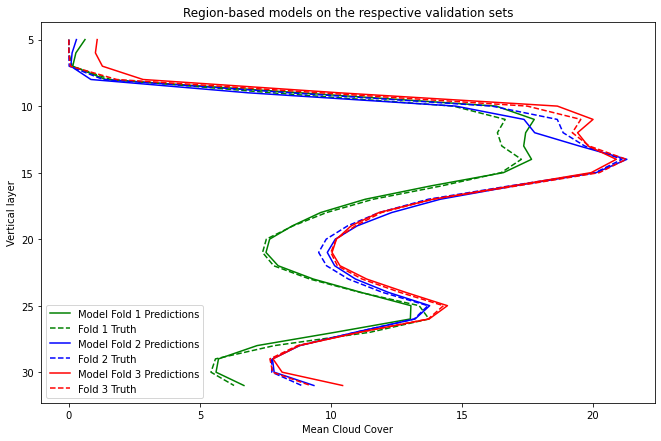

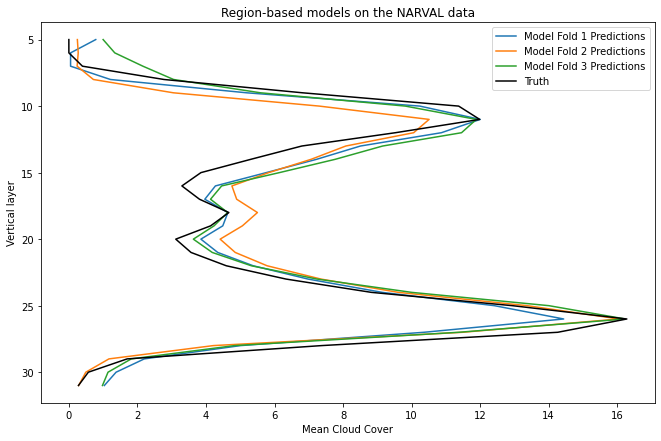

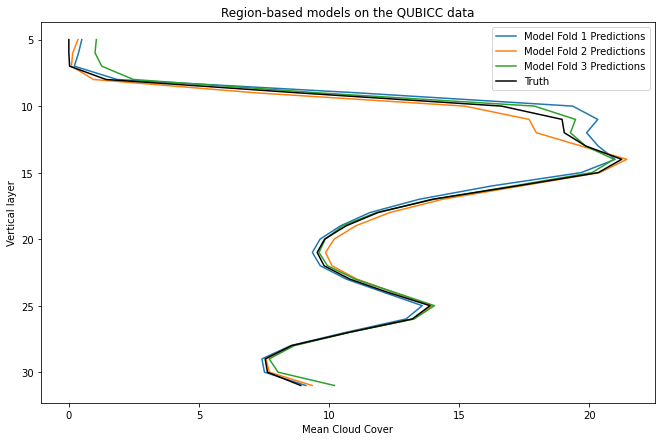

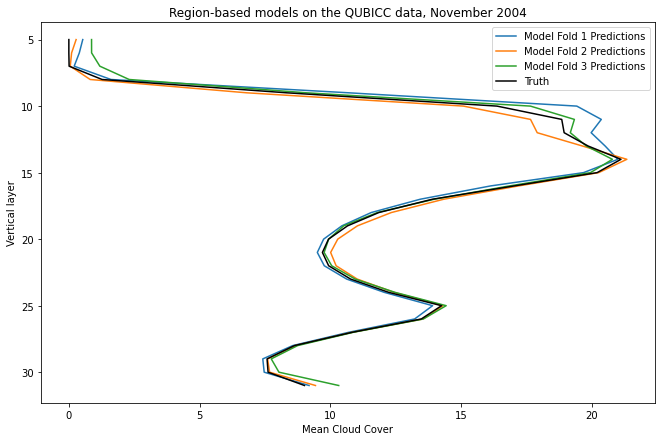

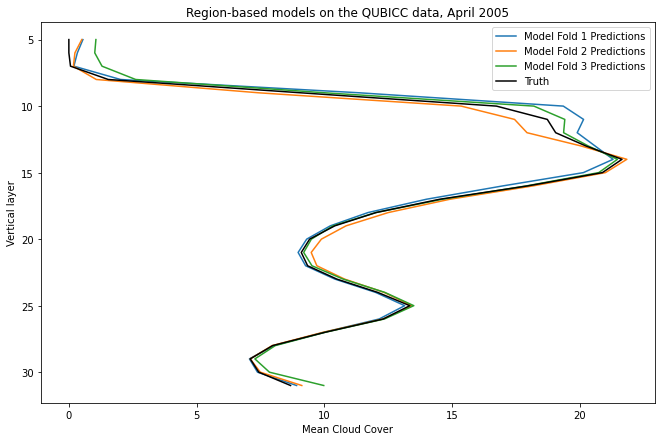

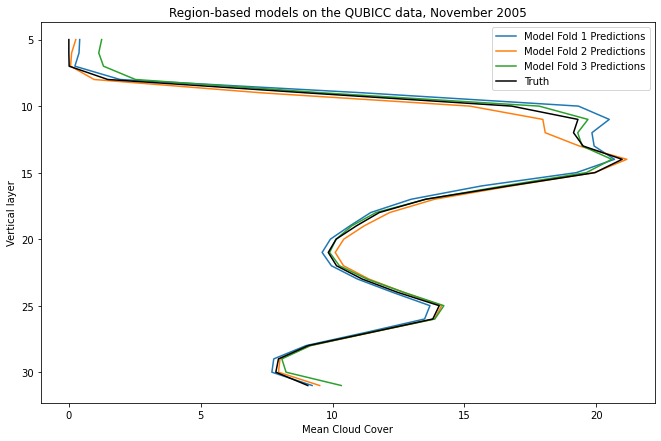

In [26]:
# # Plot results
save_figure('cross_validation_validation_means', 'Region-based models on the respective validation sets', 
            valid_model_predictions, valid_means, all_data_model)
save_figure('cross_validation_narval', 'Region-based models on the NARVAL data', 
            narval_model_predictions, narval_means, all_data_model)
save_figure('cross_validation_qubicc', 'Region-based models on the QUBICC data', 
            qubicc_model_predictions, qubicc_means, all_data_model)

# Qubicc months
save_figure('cross_validation_qubicc_hc2', 'Region-based models on the QUBICC data, November 2004', 
            qubicc_model_pred_month_0, qubicc_month_0, all_data_model)
save_figure('cross_validation_qubicc_hc3', 'Region-based models on the QUBICC data, April 2005', 
            qubicc_model_pred_month_1, qubicc_month_1, all_data_model)
save_figure('cross_validation_qubicc_hc4', 'Region-based models on the QUBICC data, November 2005', 
            qubicc_model_pred_month_2, qubicc_month_2, all_data_model)

#### Compute bounded losses

We also save the scaling parameters for the fold-based models as we haven't done that yet.

In [27]:
def compute_bounded_loss(model, input_data, output_data, batch_size=2**20):
    for i in range(1 + input_data.shape[0]//batch_size):
        if i == 0:
            a = model.predict_on_batch(input_data[i*batch_size:(i+1)*batch_size])
        else:
            a = np.concatenate((a, model.predict_on_batch(input_data[i*batch_size:(i+1)*batch_size])), axis=0)
        K.clear_session()
        gc.collect()
        
    # Bounded output! a[:,0] needed if there's only one output
    pred_adj = np.minimum(np.maximum(a[:,0], 0), 100)
    
    # Mean Squared Error
    return np.mean((pred_adj - output_data)**2, dtype=np.float64)

In [ ]:
seed = 10

for i in range(3):  # for i in range(3): 
    filename = 'cross_validation_region_based_fold_%d'%(i+1)
    # Choose appropriate model for this fold
    if i == 0: model = model_fold_1
    if i == 1: model = model_fold_2
    if i == 2: model = model_fold_3
        
    #Standardize according to the fold
    scaler.fit(input_data[training_folds[i]])
    
    # We save the scaling parameters in a file [only once]
    seed_i = int(str(seed) + str(i))
    with open(path_model+'/scaler_%d.txt'%seed_i, 'a') as file:
        file.write('Standard Scaler mean values:\n')
        file.write(str(scaler.mean_))
        file.write('\nStandard Scaler standard deviation:\n')
        file.write(str(np.sqrt(scaler.var_)))

    # Taken from preprocessing_narval
    input_variables = np.array(['qv', 'qc', 'qi', 'temp', 'pres', 'u', 'v', 'zg', 'coriolis', 'qv_below', 'qv_above',
                               'qc_below', 'qc_above', 'qi_below', 'qi_above', 'temp_below', 'temp_above',
                               'pres_below', 'pres_above', 'u_below', 'u_above', 'v_below', 'v_above', 
                               'zg_below', 'zg_above','temp_sfc'])
    in_and_out_variables = np.array(['qv', 'qc', 'qi', 'temp', 'pres', 'u', 'v', 'zg', 'coriolis', 'qv_below', 'qv_above',
                               'qc_below', 'qc_above', 'qi_below', 'qi_above', 'temp_below', 'temp_above',
                               'pres_below', 'pres_above', 'u_below', 'u_above', 'v_below', 'v_above', 'zg_below', 
                               'zg_above','temp_sfc', output_var])

    # Write the accompanying info-file [only once]
    with open(os.path.join(path_model, filename + '.txt'), 'a') as file:
        write_infofile(file, str(in_and_out_variables), str(input_variables), path_model, path_data, seed_i)
    
    #Load the data for the respective fold
    input_train = scaler.transform(input_data[training_folds[i]])
    input_valid = scaler.transform(input_data[validation_folds[i]])
    output_train = output_data[training_folds[i]]
    output_valid = output_data[validation_folds[i]]
    
    train_loss = compute_bounded_loss(model, input_train, output_train, batch_size=2**15)
    valid_loss = compute_bounded_loss(model, input_valid, output_valid, batch_size=2**15)
        
    with open(os.path.join(path_model, filename+'.txt'), 'a') as file:
        file.write('Bounded training loss: %.4f\n'%(train_loss))
        file.write('Bounded validation loss: %.4f\n'%(valid_loss))

Trained on all data

In [ ]:
if all_data_model:
    filename = 'region_based_all_data_seed_10'
    model = model_all_data

    #Standardize according to the fold
    scaler.fit(input_data)

    #Load the data for the respective fold
    input_train = scaler.transform(input_data)
    output_train = output_data

    train_loss = compute_bounded_loss(model, input_train, output_train, batch_size=2**15)

    with open(os.path.join(path_model, filename+'.txt'), 'a') as file:
        file.write('Bounded training loss: %.4f\n'%(train_loss))